In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.utils import shuffle
from IPython.display import clear_output
from datetime import datetime
import pandas as pd
df=pd.read_csv('sample_images/fer2013.csv', sep=',',header=0)
df_train=df[df['Usage']=='Training']
df_test=df[df['Usage']!='Training']
del df

def str2image(x):
    return np.fromstring(x,sep=' ')

def convertFlat2Image(df):
    mat=df['pixels'].as_matrix()
    r_mat=np.array([str2image(xi).reshape(48,48,1) for xi in mat])
    return r_mat

X_train=convertFlat2Image(df_train)
X_test=convertFlat2Image(df_test)
y_train=df_train['emotion'].as_matrix()
y_test=df_test['emotion'].as_matrix()

In [82]:
def error_rate(p,t):
    return np.mean(p!=t)


def convpool(X,W,b):
    conv_out=tf.nn.conv2d(X,W,strides=[1,1,1,1],padding="SAME")
    conv_out=tf.nn.bias_add(conv_out,b)
    pool_out=tf.nn.max_pool(conv_out,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return pool_out

def convnopool(X,W,b):
    conv_out=tf.nn.conv2d(X,W,strides=[1,1,1,1],padding="SAME")
    conv_out=tf.nn.bias_add(conv_out,b)
#     pool_out=tf.nn.max_pool(conv_out,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return conv_out


def init_filter(shape,poolsz):
    w=np.random.randn(*shape)/np.sqrt(np.prod(shape[:-1])+shape[-1]*np.prod(shape[:-2]/np.prod(poolsz)))
    return w.astype(np.float32)

def init_dense(shape):
    w=np.random.randn(*shape)/np.sqrt(np.sum(shape))
    return w.astype(np.float32)

from functools import partial
he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") # he init method
scale=0.01
my_dense=partial(tf.layers.dense,activation=tf.nn.elu,
                 kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                 kernel_initializer=he_init)

def main():
    Xtrain=X_train[:28000,]/255
    Ytrain=y_train[:28000]
    Xtest=X_test[:7000,]/255
    Ytest=y_test[:7000]
    
    n_epochs=100
    N=Xtrain.shape[0]
    batch_sz=100
    n_batches=N//batch_sz
    pool_sz=(2,2)

    learning_rate=0.001
    tf.reset_default_graph()
    # cnn_pool layer 1
    W1_shape=(3,3,1,20)
    W1_init=init_filter(W1_shape,pool_sz)
    b1_init=np.zeros(W1_shape[-1],dtype=np.float32)

    # cnn_pool layer 2
    W2_shape=(3,3,20,40)
    W2_init=init_filter(W2_shape,pool_sz)
    b2_init=np.zeros(W2_shape[-1],dtype=np.float32)
    
    pool_sz=(1,1)
    # cnn_pool layer 3
    W3_shape=(5,5,40,80)
    W3_init=init_filter(W3_shape,pool_sz)
    b3_init=np.zeros(W3_shape[-1],dtype=np.float32)

    # cnn_pool layer 4
    W4_shape=(3,3,80,128)
    W4_init=init_filter(W4_shape,pool_sz)
    b4_init=np.zeros(W4_shape[-1],dtype=np.float32)

    X=tf.placeholder(tf.float32,shape=(None,48,48,1),name="X")
    y=tf.placeholder(tf.int64,shape=(None),name="y")

    with tf.name_scope("cnn"):
        with tf.device("/gpu:0"):
            W1=tf.Variable(W1_init.astype(np.float32))
            b1=tf.Variable(b1_init.astype(np.float32))
            W2=tf.Variable(W2_init.astype(np.float32))
            b2=tf.Variable(b2_init.astype(np.float32)) 
            Z1=convpool(X,W1,b1)
            Z2=convpool(Z1,W2,b2)
            W3=tf.Variable(W3_init.astype(np.float32))
            b3=tf.Variable(b3_init.astype(np.float32))
            Z3=convnopool(Z2,W3,b3)
            
        with tf.device("/gpu:1"):    
            W4=tf.Variable(W4_init.astype(np.float32))
            b4=tf.Variable(b4_init.astype(np.float32))
            Z4=convnopool(Z3,W4,b4)

    n_hidden1=2048
    n_hidden2=n_hidden1
    n_hidden3=n_hidden2//4
    n_outputs=7
    with tf.name_scope("dnn"):
        dropout_rate=0.4
        training=tf.placeholder_with_default(False,shape=(),name="training")
        with tf.device("/gpu:1"):
            Z_f=tf.contrib.layers.flatten(Z4)

            hidden1=my_dense(Z_f,n_hidden1,name="hidden1",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden1_drop=tf.layers.dropout(hidden1,dropout_rate,training=training)

            hidden2=my_dense(hidden1_drop,n_hidden2,name="hidden2",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden2_drop=tf.layers.dropout(hidden2,dropout_rate,training=training)
            
            hidden3=my_dense(hidden2_drop,n_hidden3,name="hidden3",kernel_initializer=he_init,
                             activation=tf.nn.elu)
            hidden3_drop=tf.layers.dropout(hidden3,dropout_rate,training=training)
            logits=my_dense(hidden3_drop,n_outputs, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                     kernel_initializer=he_init,name="outputs")

    with tf.name_scope("loss"):
        xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
        loss=tf.reduce_mean(xentropy,name="loss")

    with tf.name_scope("train"):
        optimizer=tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                             momentum=0.95,use_nesterov=True)
        training_op=optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct=tf.nn.in_top_k(logits,y,1)
        accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))

    init=tf.global_variables_initializer()
    saver=tf.train.Saver()
    train_accuracy_save=[]
    test_accuracy_save=[]

    # calculate average accuracy
    beta=0.9
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            Xtrain,Ytrain=shuffle(Xtrain,Ytrain)
            acc_train=1
            for iteration in range(N//batch_sz):
                X_batch,y_batch=(Xtrain[iteration*batch_sz:(iteration*batch_sz+batch_sz),:],
                                 Ytrain[iteration*batch_sz:(iteration*batch_sz+batch_sz)])
                sess.run(training_op,feed_dict={X:X_batch,y:y_batch,training:True}) # dropout=True
                acc_train=beta*acc_train+(1-beta)*accuracy.eval(feed_dict={X:X_batch,y:y_batch}) # dropout=True
            acc_test=accuracy.eval(feed_dict={X:Xtest,y:Ytest})
            clear_output()
            print(logits.eval(feed_dict={X:X_batch,y:y_batch})[0])
            print(epoch+1,"Train accuracy: ",acc_train," Test accuracy: ",acc_test,end="\r")
            train_accuracy_save.append(acc_train)
            test_accuracy_save.append(acc_test)
        save_path=saver.save(sess,"model_checkpoints/fert_cnn.ckpt")

    x_number=range(1,len(test_accuracy_save)+1)
    plt.plot(x_number, train_accuracy_save, 'r--', x_number,test_accuracy_save)
    plt.show()

[ 3.14997   -1.         2.455172  -0.6582558  2.7563648 12.039327
  4.93764  ]


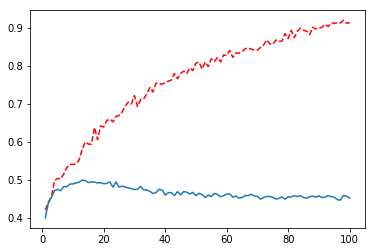

In [83]:
if __name__ == "__main__":
    main()

In [91]:
import collections
collections.Counter(y_train)

Counter({0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965})

In [92]:
collections.Counter(y_test)

Counter({0: 958, 1: 111, 2: 1024, 3: 1774, 4: 1247, 5: 831, 6: 1233})